In [1]:
import os
from datetime import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import csv
from csv import writer



#tensorflow import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam

#logging
from tensorflow import keras
from keras import backend as K


#custom functions import
from ts_functions import time_window_generator
from aux_functions import aux_functions


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
#option flags
debug_mode = True
debug_output_n = 2

performance_log = True
data_log_csv_path = "training_log/tencent_t1.csv"


#tensorboard logging doesnt work for now
tf_log_dir = "logs/LSTM_stocks/"




In [3]:
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, r"stock_data\tencent_10_22_day.csv") #stock data

In [4]:
drop_list = ['change']

df = pd.read_csv(filename).drop(drop_list, axis=1)

In [5]:
if debug_mode:
    display(df)

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
0,00700.HK,20221219,320.4,328.8,316.8,320.4,316.8,1.1400,24897178.0,8.007002e+09
1,00700.HK,20221216,314.0,321.4,311.6,316.8,317.6,-0.2500,25128603.0,7.968428e+09
2,00700.HK,20221215,325.0,326.6,316.0,317.6,325.0,-2.2800,18962052.0,6.040827e+09
3,00700.HK,20221214,322.2,327.8,318.4,325.0,318.4,2.0700,24238494.0,7.865015e+09
4,00700.HK,20221213,316.0,325.0,315.6,318.4,317.6,0.2500,20313254.0,6.497226e+09
...,...,...,...,...,...,...,...,...,...,...
2995,00700.HK,20101026,187.0,188.0,181.0,182.0,185.5,-1.8868,2791664.0,5.134564e+08
2996,00700.HK,20101025,186.5,187.2,184.6,185.5,184.9,0.3245,2032205.0,3.777241e+08
2997,00700.HK,20101022,186.0,186.4,183.2,184.9,186.1,-0.6448,2230675.0,4.122454e+08
2998,00700.HK,20101021,183.7,188.0,181.0,186.1,181.7,2.4216,4542922.0,8.424123e+08


In [6]:
if debug_mode:
    display(df.describe())

,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
count,3.000000e+03,3000.000000,3000.000000,3000.000000,3000.000000,2999.000000,2999.000000,3.000000e+03,3.000000e+03
mean,2.016446e+07,309.711133,313.459667,305.465933,309.390767,309.071720,0.099399,1.681502e+07,5.531734e+09
std,3.518952e+04,142.123773,144.075687,139.823089,141.778543,141.644585,2.206166,1.428095e+07,6.360695e+09
min,2.010102e+07,107.000000,107.800000,104.500000,105.300000,102.800000,-11.430000,8.664290e+05,1.496843e+08
25%,2.013110e+07,189.700000,190.725000,186.750000,188.800000,188.450000,-1.089950,6.752993e+06,1.583853e+09
50%,2.016112e+07,293.000000,296.700000,287.700000,292.300000,291.200000,0.060000,1.533243e+07,3.719918e+09
75%,2.019121e+07,400.300000,405.800000,396.450000,400.250000,400.100000,1.290000,2.214389e+07,7.734933e+09
max,2.022122e+07,767.000000,775.500000,751.500000,766.500000,766.500000,23.150000,3.084368e+08,1.486821e+11


# Model DataFrame preprocessing

In [7]:
#split data into different stock
# stock_list = [x.sort_values("trade_date", ascending = True) for _,x in df.groupby('ts_code')]

stock_list = []

for ts_code, x in df.groupby('ts_code'):
    stock_list.append(x.copy().sort_values("trade_date", ascending = True).reset_index().drop('index', axis=1))




#sort by trade_date, ascending
if debug_mode:
    print("number of stocks : ", len(stock_list))

number of stocks :  1


# ADD HSI into the df

In [8]:
# hsi_filename = os.path.join(fileDir, r"stock_data\hsi_07_22_day.csv")

# df_hsi = pd.read_csv(hsi_filename).drop(['index_ts_code', 'index_vol', 'index_change', 'index_vol', 'index_swing'], axis=1).sort_values("index_trade_date", ascending = True).reset_index().drop('index', axis=1)

# display(df_hsi)

In [9]:
# #append hs300 by matching dates
# invalid_stock_list = []# the stock that is fucked


# for i in range(len(stock_list)):
#     stock = stock_list[i]
#     if stock['trade_date'].iloc[-1] != df_hs300['index_trade_date'].iloc[-1]:
#         invalid_stock_list.append(i)


In [10]:
# # for i in invalid_stock_list:
# #     print(stock_list[i].head(1))

# invalid_stock_list = sorted(invalid_stock_list, reverse=True)

# print(invalid_stock_list)


# for i in invalid_stock_list:
#     stock_list.pop(i)

In [11]:
# stock_list[0]['trade_date']
# print(len(stock_list[0]['trade_date']))

# tx = df_hsi[df_hsi['index_trade_date'].isin(stock_list[0]['trade_date'])].sort_values("index_trade_date", ascending = True).reset_index().drop('index', axis=1)
# display(tx)

# display(stock_list[0])

# display(df_hsi)

# txp = pd.concat([stock_list[0], tx], axis=1, join='inner')
# display(txp)

In [12]:
# #concat

# for i in range(len(stock_list)):

#     temp = df_hsi[df_hsi['index_trade_date'].isin(stock_list[i]['trade_date'])].sort_values("index_trade_date", ascending = True).reset_index().drop('index', axis=1)
#     stock_list[i] = pd.concat([stock_list[i], temp], axis=1, join='inner')#.drop('index_trade_date', axis=1)

#     # stock_list[i] = stock_list[i].join(df_hsi, on='str', lsuffix='trade_date', rsuffix='index_trade_date', how='inner')





In [13]:
# display(stock_list[0])

In [14]:
#check time matching
# for stock in stock_list:
#     print(stock['trade_date'].isin(stock['index_trade_date']).value_counts())

In [15]:
display(stock_list[0][0:15])

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
0,00700.HK,20101020,181.8,183.6,180.3,181.7,184.3,-1.4108,3832744.0,6.983709e+08
1,00700.HK,20101021,183.7,188.0,181.0,186.1,181.7,2.4216,4542922.0,8.424123e+08
2,00700.HK,20101022,186.0,186.4,183.2,184.9,186.1,-0.6448,2230675.0,4.122454e+08
3,00700.HK,20101025,186.5,187.2,184.6,185.5,184.9,0.3245,2032205.0,3.777241e+08
4,00700.HK,20101026,187.0,188.0,181.0,182.0,185.5,-1.8868,2791664.0,5.134564e+08
5,00700.HK,20101027,182.0,184.0,178.3,178.7,182.0,-1.8132,2910649.0,5.243529e+08
6,00700.HK,20101028,180.4,180.4,174.5,176.5,178.7,-1.2311,3066501.0,5.427420e+08
7,00700.HK,20101029,177.2,182.1,175.0,177.5,176.5,0.5666,4869726.0,8.726040e+08
8,00700.HK,20101101,186.0,186.2,183.0,185.0,177.5,4.2254,3233693.0,5.945954e+08
9,00700.HK,20101102,188.0,188.0,183.0,185.3,185.0,0.1622,3853103.0,7.130409e+08


# add time periodicity

In [16]:
#setup timestamp for year periodicity 
date_time_db = []

for stock_i in stock_list:
    date_time_db.append(pd.to_datetime(stock_i.pop('trade_date'), format='%Y%m%d'))

In [17]:
if debug_mode:
    print(date_time_db[0])

0      2010-10-20
1      2010-10-21
2      2010-10-22
3      2010-10-25
4      2010-10-26
          ...    
2995   2022-12-13
2996   2022-12-14
2997   2022-12-15
2998   2022-12-16
2999   2022-12-19
Name: trade_date, Length: 3000, dtype: datetime64[ns]


In [18]:
date_time_stamp_db = []

for dt in date_time_db:
    date_time_stamp_db.append(dt.map(pd.Timestamp.timestamp))

In [19]:
if debug_mode:
    date_time_stamp_db[0]

In [20]:
year = 24*60*60*(365.2425)

for i in range(len(stock_list)):
    
    stock_list[i]["Year sin"] = np.sin(date_time_stamp_db[i] * (2 * np.pi / year))
    stock_list[i]["Year cos"] = np.cos(date_time_stamp_db[i] * (2 * np.pi / year))
    

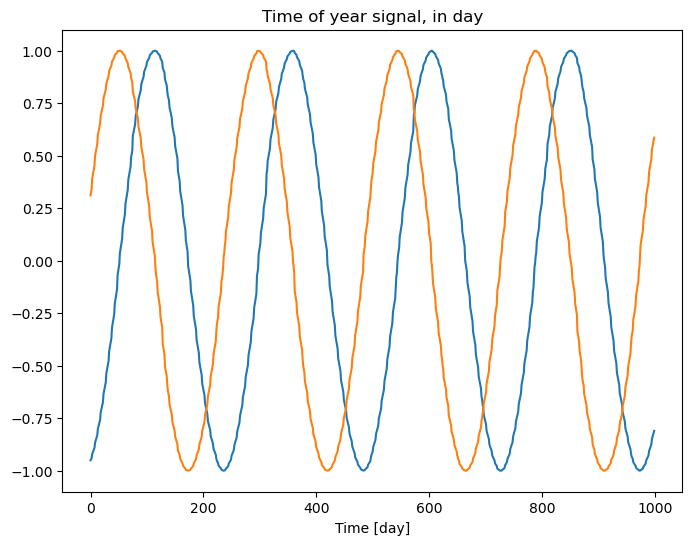

In [21]:
if debug_mode:
    plt.plot(np.array(stock_list[0]['Year sin'])[:1000])
    plt.plot(np.array(stock_list[0]['Year cos'])[:1000])
    plt.xlabel('Time [day]')
    plt.title('Time of year signal, in day')

In [22]:
if debug_mode:
    display(stock_list[0].head())

,ts_code,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos
0,00700.HK,181.8,183.6,180.3,181.7,184.3,-1.4108,3832744.0,698370925.0,-0.950491,0.310751
1,00700.HK,183.7,188.0,181.0,186.1,181.7,2.4216,4542922.0,842412288.0,-0.945005,0.327055
2,00700.HK,186.0,186.4,183.2,184.9,186.1,-0.6448,2230675.0,412245422.0,-0.939239,0.343263
3,00700.HK,186.5,187.2,184.6,185.5,184.9,0.3245,2032205.0,377724143.0,-0.920282,0.391257
4,00700.HK,187.0,188.0,181.0,182.0,185.5,-1.8868,2791664.0,513456395.0,-0.913415,0.407029


In [23]:
#df processing
for stock in stock_list:
    stock.name = stock.iloc[0,0]
    stock.pop("ts_code") #pop the stock code
    #stock.pop("pre_close") #pop previous day close price

In [24]:
if debug_mode:
    display(stock_list[0].head())

,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos
0,181.8,183.6,180.3,181.7,184.3,-1.4108,3832744.0,698370925.0,-0.950491,0.310751
1,183.7,188.0,181.0,186.1,181.7,2.4216,4542922.0,842412288.0,-0.945005,0.327055
2,186.0,186.4,183.2,184.9,186.1,-0.6448,2230675.0,412245422.0,-0.939239,0.343263
3,186.5,187.2,184.6,185.5,184.9,0.3245,2032205.0,377724143.0,-0.920282,0.391257
4,187.0,188.0,181.0,182.0,185.5,-1.8868,2791664.0,513456395.0,-0.913415,0.407029


# MA implementation

In [25]:
ma_label = 'open'

In [26]:
for stock in stock_list:
    
    #MA

    processing_row = stock[ma_label].to_frame()

    stock['sma5'] = processing_row[ma_label].rolling(5).mean()

    stock['ema5'] = processing_row[ma_label].ewm(span=5).mean()

    stock['ema20'] = processing_row[ma_label].ewm(span=20).mean()

    stock['ema50'] = processing_row[ma_label].ewm(span=50).mean()

    

    # # Golden Cross  implementation
    # np.where(stock['ema20'] > stock['ema50'], 1, 0)

    # stock['ema20_50_GC'] = 0 

    # for i in range(stock.shape[0]):
    #     if i == 0:
    #         pass
    #     elif stock['ema20'][i] >= stock['ema50'][i] and stock['ema20'][i-1] < stock['ema50'][i-1]: #slow code, works for now
    #         stock['ema20_50_GC'][i] = 1



    stock.dropna(inplace=True)
    

In [27]:
# #GC value count inspction
# for stock in stock_list:
#     print(stock['ema20_50_GC'].value_counts())



In [29]:
display(stock_list[0])

,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
4,187.0,188.0,181.0,182.0,185.5,-1.8868,2791664.0,5.134564e+08,-0.913415,0.407029,185.00,185.931754,185.258487,185.104804
5,182.0,184.0,178.3,178.7,182.0,-1.8132,2910649.0,5.243529e+08,-0.906278,0.422682,185.04,184.495038,184.571095,184.534239
6,180.4,180.4,174.5,176.5,178.7,-1.2311,3066501.0,5.427420e+08,-0.898873,0.438209,184.38,183.045168,183.782444,183.870449
7,177.2,182.1,175.0,177.5,176.5,0.5666,4869726.0,8.726040e+08,-0.891202,0.453606,182.62,181.017669,182.644636,182.915344
8,186.0,186.2,183.0,185.0,177.5,4.2254,3233693.0,5.945954e+08,-0.866616,0.498975,182.52,182.722800,183.182852,183.315423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,316.0,325.0,315.6,318.4,317.6,0.2500,20313254.0,6.497226e+09,-0.318660,0.947869,313.44,313.213622,292.992047,279.677381
2996,322.2,327.8,318.4,325.0,318.4,2.0700,24238494.0,7.865015e+09,-0.302308,0.953210,315.92,316.209081,295.773756,281.344935
2997,325.0,326.6,316.0,317.6,325.0,-2.2800,18962052.0,6.040827e+09,-0.285866,0.958270,320.08,319.139388,298.557208,283.056898
2998,314.0,321.4,311.6,316.8,317.6,-0.2500,25128603.0,7.968428e+09,-0.269339,0.963045,319.12,317.426258,300.027950,284.270353


# Final data check

In [30]:
display(stock_list[0])


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
4,187.0,188.0,181.0,182.0,185.5,-1.8868,2791664.0,5.134564e+08,-0.913415,0.407029,185.00,185.931754,185.258487,185.104804
5,182.0,184.0,178.3,178.7,182.0,-1.8132,2910649.0,5.243529e+08,-0.906278,0.422682,185.04,184.495038,184.571095,184.534239
6,180.4,180.4,174.5,176.5,178.7,-1.2311,3066501.0,5.427420e+08,-0.898873,0.438209,184.38,183.045168,183.782444,183.870449
7,177.2,182.1,175.0,177.5,176.5,0.5666,4869726.0,8.726040e+08,-0.891202,0.453606,182.62,181.017669,182.644636,182.915344
8,186.0,186.2,183.0,185.0,177.5,4.2254,3233693.0,5.945954e+08,-0.866616,0.498975,182.52,182.722800,183.182852,183.315423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,316.0,325.0,315.6,318.4,317.6,0.2500,20313254.0,6.497226e+09,-0.318660,0.947869,313.44,313.213622,292.992047,279.677381
2996,322.2,327.8,318.4,325.0,318.4,2.0700,24238494.0,7.865015e+09,-0.302308,0.953210,315.92,316.209081,295.773756,281.344935
2997,325.0,326.6,316.0,317.6,325.0,-2.2800,18962052.0,6.040827e+09,-0.285866,0.958270,320.08,319.139388,298.557208,283.056898
2998,314.0,321.4,311.6,316.8,317.6,-0.2500,25128603.0,7.968428e+09,-0.269339,0.963045,319.12,317.426258,300.027950,284.270353


# Models Area

In [31]:
# stacked_lstm_1 = Sequential(

#     [

#         LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 1, activation = 'linear') #output 

#     ],

#     name = "simple_stacked_lstm_stock_1"

# )

In [32]:
# stacked_lstm_1_plus = Sequential(

#     [

#         LSTM(units = 64, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         LSTM(units = 64, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 1, activation = 'linear') #output 

#     ],

#     name = "simple_stacked_lstm_stock_1_plus"

# )

# Training for all models

In [33]:
#data storage
evaluation_result = {}


#meta data
labels = ['open']

eval_iteration = 10 #the number of evaluation iterations for individual stock

df instances :  2995
df features :  14


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
4,187.0,188.0,181.0,182.0,185.5,-1.8868,2791664.0,5.134564e+08,-0.913415,0.407029,185.00,185.931754,185.258487,185.104804
5,182.0,184.0,178.3,178.7,182.0,-1.8132,2910649.0,5.243529e+08,-0.906278,0.422682,185.04,184.495038,184.571095,184.534239
6,180.4,180.4,174.5,176.5,178.7,-1.2311,3066501.0,5.427420e+08,-0.898873,0.438209,184.38,183.045168,183.782444,183.870449
7,177.2,182.1,175.0,177.5,176.5,0.5666,4869726.0,8.726040e+08,-0.891202,0.453606,182.62,181.017669,182.644636,182.915344
8,186.0,186.2,183.0,185.0,177.5,4.2254,3233693.0,5.945954e+08,-0.866616,0.498975,182.52,182.722800,183.182852,183.315423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,316.0,325.0,315.6,318.4,317.6,0.2500,20313254.0,6.497226e+09,-0.318660,0.947869,313.44,313.213622,292.992047,279.677381
2996,322.2,327.8,318.4,325.0,318.4,2.0700,24238494.0,7.865015e+09,-0.302308,0.953210,315.92,316.209081,295.773756,281.344935
2997,325.0,326.6,316.0,317.6,325.0,-2.2800,18962052.0,6.040827e+09,-0.285866,0.958270,320.08,319.139388,298.557208,283.056898
2998,314.0,321.4,311.6,316.8,317.6,-0.2500,25128603.0,7.968428e+09,-0.269339,0.963045,319.12,317.426258,300.027950,284.270353


train_df instances :  2096


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
4,187.0,188.0,181.0,182.0,185.5,-1.8868,2791664.0,5.134564e+08,-0.913415,0.407029,185.00,185.931754,185.258487,185.104804
5,182.0,184.0,178.3,178.7,182.0,-1.8132,2910649.0,5.243529e+08,-0.906278,0.422682,185.04,184.495038,184.571095,184.534239
6,180.4,180.4,174.5,176.5,178.7,-1.2311,3066501.0,5.427420e+08,-0.898873,0.438209,184.38,183.045168,183.782444,183.870449
7,177.2,182.1,175.0,177.5,176.5,0.5666,4869726.0,8.726040e+08,-0.891202,0.453606,182.62,181.017669,182.644636,182.915344
8,186.0,186.2,183.0,185.0,177.5,4.2254,3233693.0,5.945954e+08,-0.866616,0.498975,182.52,182.722800,183.182852,183.315423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,390.0,391.8,382.6,382.8,393.0,-2.6000,15543878.0,6.021222e+09,0.924016,-0.382353,393.24,392.434321,381.880466,365.260980
2096,380.0,385.8,380.0,384.0,382.8,0.3100,12886453.0,4.938041e+09,0.917302,-0.398191,390.52,388.289547,381.701374,365.838981
2097,384.0,391.8,384.0,390.6,384.0,1.7200,13451044.0,5.228428e+09,0.895540,-0.444981,388.72,386.859698,381.920290,366.551178
2098,386.0,390.4,384.4,388.0,390.6,-0.6700,9657162.0,3.741571e+09,0.887753,-0.460320,387.56,386.573132,382.308834,367.313877






val_df instances :  599


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
2100,387.2,389.6,384.6,387.8,391.4,-0.92,9661796.0,3.740555e+09,0.862825,-0.505502,385.44,387.543614,383.437390,368.948488
2101,373.0,377.4,370.2,375.6,387.8,-3.15,22726831.0,8.502210e+09,0.835600,-0.549338,384.04,382.695743,382.443353,369.107371
2102,376.2,381.2,374.0,380.8,375.6,1.38,17287049.0,6.520234e+09,0.826027,-0.563631,382.48,380.530495,381.848748,369.385514
2103,379.0,395.0,376.4,384.8,380.8,1.05,34223197.0,1.325093e+10,0.816209,-0.577757,381.08,380.020330,381.577439,369.762552
2104,384.8,387.6,375.6,375.6,384.8,-2.39,19800539.0,7.532670e+09,0.806150,-0.591712,380.04,381.613553,381.884349,370.352256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,459.0,473.0,455.2,464.6,460.2,0.96,17966998.0,8.374945e+09,-0.997266,-0.073894,456.64,458.455959,468.424223,487.764201
2696,467.0,476.2,464.6,469.8,464.6,1.12,20947276.0,9.885230e+09,-0.998390,-0.056728,458.72,461.303973,468.288582,486.949918
2697,461.6,465.0,450.2,465.0,469.8,-1.02,18250450.0,8.374555e+09,-0.999218,-0.039545,461.84,461.402648,467.651575,485.955804
2698,456.0,464.6,453.8,461.4,465.0,-0.77,17335451.0,7.955885e+09,-0.999750,-0.022351,461.00,459.601766,466.541901,484.781066






test_df instances :  300


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
2700,446.2,453.6,445.4,450.0,457.0,-1.53,11881767.0,5.338522e+09,-0.997974,0.063618,460.16,457.445229,464.902554,482.711165
2701,454.0,454.0,445.6,446.4,450.0,-0.80,10847755.0,4.864491e+09,-0.996732,0.080776,457.56,456.296819,463.864215,481.585237
2702,455.0,472.8,454.2,471.4,446.4,5.60,14550659.0,6.754438e+09,-0.995195,0.097909,456.24,455.864546,463.020004,480.542679
2703,490.0,490.0,472.0,481.8,471.4,2.21,29806385.0,1.437582e+10,-0.993364,0.115014,463.04,467.243031,465.589528,480.913554
2704,492.6,498.6,489.0,496.0,481.8,2.95,26204010.0,1.295062e+10,-0.986108,0.166104,467.56,475.695354,468.161954,481.371846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,316.0,325.0,315.6,318.4,317.6,0.25,20313254.0,6.497226e+09,-0.318660,0.947869,313.44,313.213622,292.992047,279.677381
2996,322.2,327.8,318.4,325.0,318.4,2.07,24238494.0,7.865015e+09,-0.302308,0.953210,315.92,316.209081,295.773756,281.344935
2997,325.0,326.6,316.0,317.6,325.0,-2.28,18962052.0,6.040827e+09,-0.285866,0.958270,320.08,319.139388,298.557208,283.056898
2998,314.0,321.4,311.6,316.8,317.6,-0.25,25128603.0,7.968428e+09,-0.269339,0.963045,319.12,317.426258,300.027950,284.270353


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['open']
(TensorSpec(shape=(None, 6, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (8, 6, 14)
Labels shape (batch, time, features): (8, 1, 1)
Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Label indices: [29]
Label column name(s): ['open']
(TensorSpec(shape=(None, 29, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (8, 29, 14)
Labels shape (batch, time, features): (8, 1, 1)
Epoch 1/60
259/259 [==============================] - 35s 49ms/step - loss: 0.2282 - mean_absolute_percentage_error: 283.4550 - val_loss: 0.3984 - val_mean_absolute_percentage_error: 15.2720 - lr: 0.0010
Epoch 2/60
259/259 [==============================] - 3s 12ms/step - loss:

IndexError: list index out of range

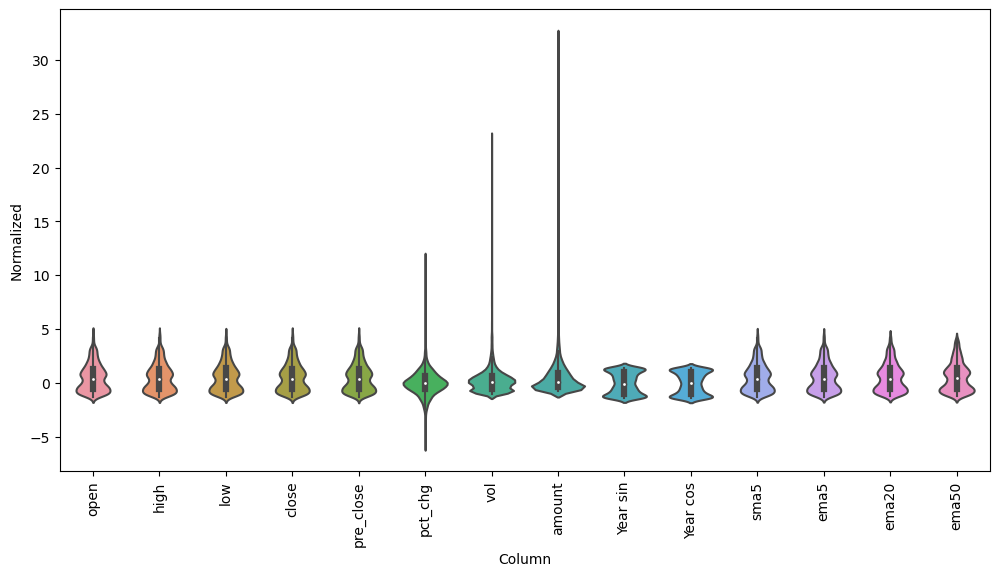

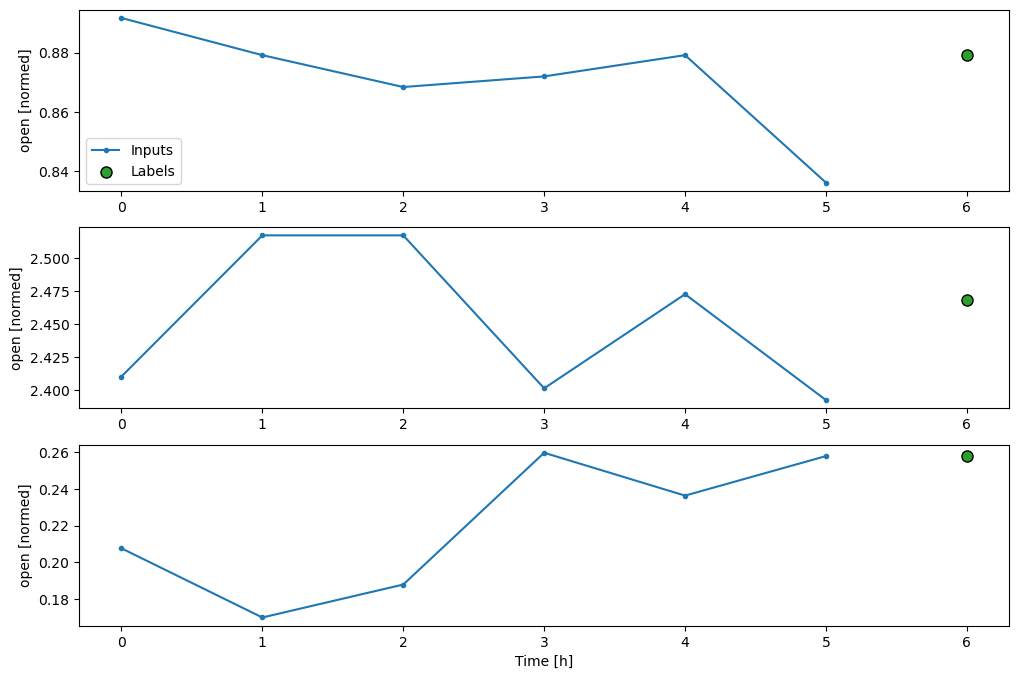

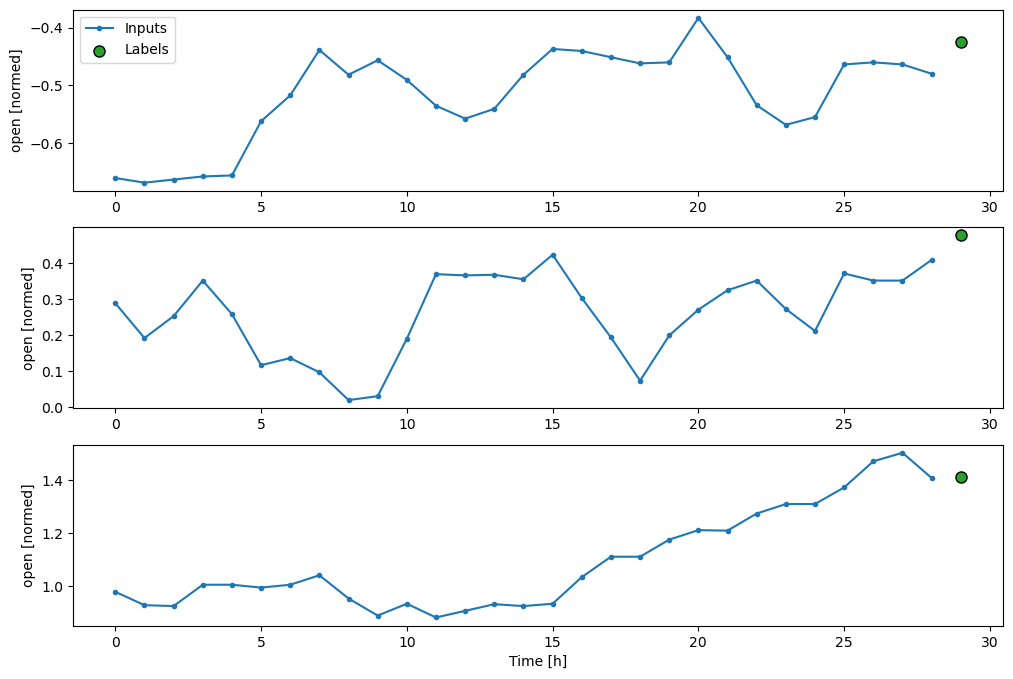

In [34]:



#main training loop
stock_training_range = 10 #len(stock_list)

learning_rate = 0.001

for stock_index in range(50):


    #set up

    current_stock = stock_list[stock_index] #df

    column_indices = {name: i for i, name in enumerate(current_stock.columns)}

    n = len(current_stock)
    num_features = current_stock.shape[1]
    num_row = current_stock.shape[0]

    #split training, cross val and testing data
    #note since this is a time series data, the split is fixed. No randomization
    #no testing data, only cross val data

    train_data_p = 0.7  #percentage of train data
    val_data_p = 0.2

    train_df = current_stock[ 0 : int(n * train_data_p) ]
    val_df = current_stock[int( n * train_data_p) : int(n * (train_data_p + val_data_p)) ]
    test_df = current_stock[int( n * (train_data_p + val_data_p)) : ]


    #debug area
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        print("df instances : ", num_row)
        print("df features : ", num_features)
        display(current_stock)


    if debug_mode and stock_index < debug_output_n : 
        print("train_df instances : ", len(train_df))
        display(train_df)
        
        for x in range(4): 
            print()
            
        print("val_df instances : ", len(val_df))
        display(val_df)
        
        for x in range(4): 
            print()
            
        print("test_df instances : ", len(test_df))
        display(test_df)
    ########################################################################


    #normalize data
    train_mean = train_df.mean()
    train_std = train_df.std()

    #compute the z score to normalize data between features
    train_df = (train_df - train_mean)/train_std
    val_df = (val_df - train_mean)/train_std
    test_df = (test_df - train_mean)/train_std


    #visuliazation
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        df_std = (current_stock - train_mean) / train_std
        df_std = df_std.melt(var_name='Column', value_name='Normalized')
        plt.figure(figsize=(12, 6))
        ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
        _ = ax.set_xticklabels(current_stock.keys(), rotation=90)
    ########################################################################



    #window setup area
    ##############################################################################################

    #set up the 7 timesteps window
    win_7 = time_window_generator(input_width = 6, label_width = 1, shift = 1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns = labels)
    #set up the batch size
    win_7.batch_size = 8

    if debug_mode and stock_index < debug_output_n :
        print(win_7)
        aux_functions.window_inspection(win_7, debug_mode, labels)
    


    #set up 30 timesteps window
    win_30 = time_window_generator(input_width = 29, label_width = 1, shift = 1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns = labels)
    #set up the batch size
    win_30.batch_size = 8

    if debug_mode and stock_index < debug_output_n :
        print(win_30)
        aux_functions.window_inspection(win_30, debug_mode, labels)

    ##############################################################################################








    #individual stock model performance evaluate 
    result = []



    #train models for n numbers of iteration to check the performance
    for iter in range(eval_iteration):

        #clear backend, prevent memory overflow
        tf.keras.backend.clear_session()

        #tensorboard logging doesnt work for now
        # logpath_exact = tf_log_dir + str(stock_list[stock_index].name) + datetime.now().strftime("%Y%m%d-%H%M%S")
        # tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logpath_exact)


        #temp model area
        ##############################################################################################


        stacked_lstm_1 = Sequential(

            [

                LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 1, activation = 'linear') #output 

            ],

            name = "simple_stacked_lstm_stock_1"

        )



        stacked_lstm_2_multilr = Sequential(

            [

                LSTM(units = 64, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                LSTM(units = 64, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 1, activation = 'linear') #output 

            ],

            name = "simple_stacked_lstm_2_multilr"

        )





        ##############################################################################################



        #chose model to run and evaluate
        train_target = win_30
        train_model = stacked_lstm_2_multilr



        #compile and fit
        data_model = aux_functions.compile_and_fit(train_model, train_target, epochs=60, es_patience=4, es_monitor='val_loss', es_mode='min', lr=learning_rate)


        result.append([train_model.evaluate(train_target.val), train_model.evaluate(train_target.test)])
    




    average_mape_val = 0
    average_mape_test = 0
    
    for result_i in range(len(result)):
        average_mape_val += result[result_i][0][1]
        average_mape_test += result[result_i][1][1]
    
    average_mape_val = average_mape_val/len(result)
    average_mape_test = average_mape_test/len(result)



    evaluation_result[stock_list[stock_index].name] = [average_mape_val, average_mape_test, result]



    #data logging

    if performance_log == True:

        performance_log_csv = open(data_log_csv_path, 'a', encoding='UTF8', newline='')
        csv_writer = csv.writer(performance_log_csv)
        csv_writer.writerow([stock_list[stock_index].name, average_mape_val, average_mape_test, eval_iteration, len(train_df), len(val_df), len(test_df), train_model.name])
        performance_log_csv.close()


    #garbage collection test 1
    del train_model



In [ ]:
#check all output of the dictionaries db

for key, value in evaluation_result.items():
    print("Stock Model for : ", key)
    print("Average MAPE of val data_set : ", value[0])
    print("Average MAPE of test data_set : ", value[1])
    print()

In [ ]:

# header = ["stock_code","Average MAPE of val data_set", "Average MAPE of test data_set", "Iteration_number"]   

# with open("training_log/simple_models.csv", 'w', encoding='UTF8', newline='') as file:

#     writer = csv.writer(file)

#     writer.writerow(header)

#     for key, value in evaluation_result.items():
#         writer.writerow([key, value[0], value[1]])